In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.optimize import newton, curve_fit

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    files = [file[0].data for file in files]
    return np.array(files)
    
def lazy_load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    return files

def num_sd(arr):
    
    return np.abs(arr - arr.mean()) / arr.std()
    
def apply_mask(arr, mask):
    
    arr = arr.astype(np.float32)
    
    arr *= mask
    arr[1:-1, 1:-1] += ~mask[1:-1, 1:-1] * 0.25 * \
                      (arr[:-2, 1:-1] + arr[2:, 1:-1] +
                       arr[1:-1, :-2] + arr[1:-1, 2:])
    return arr

In [3]:
reduced_star = load_plz("data/*star_re*")[0]

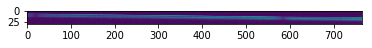

In [4]:
cropped = reduced_star[15:45,:]
plt.imshow(cropped)

In [5]:
temp = 11361
temp_err = 66 
h = 6.626e-34
c = 3*10**8
k = 1.381e-23
def blackbody(Lambda, T):
    return 2*h*c**2/Lambda**5/(np.exp(h*c/(Lambda*k*T))-1)    

In [6]:
attempt0 = np.mean(cropped,axis=0)

for i in range(len(attempt0)):
    if attempt0[i] == np.min(attempt0):
        H_abs_loc = i
    if attempt0[i] == np.min(attempt0[500:650]):
        H_abs2 = i
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift1 = (4341 - H_abs_loc*ang_per_pixel)        #lower level calibrations 
shift2 = (4861 - H_abs2*ang_per_pixel)           #to get an idea of the right answer
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift = (shift1 + shift2) / 2
x = np.linspace(shift,(shift+len(attempt0)), 765)

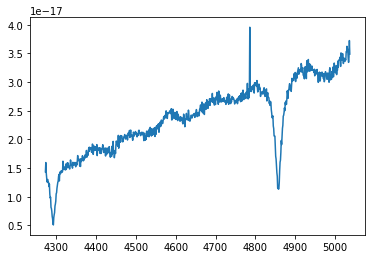

In [7]:
star_spec = attempt0/blackbody(x*1e-10,temp) #divide out some good blackbody stuff
plt.plot(x,star_spec)
#plt.plot(x, blackbody(x*1e-10,temp)/1e37)

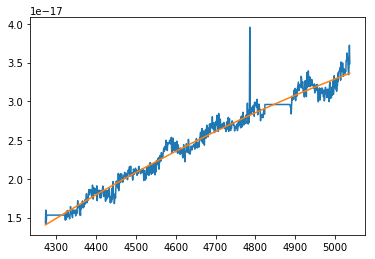

In [8]:
for i in range(len(star_spec)):
    if 2<i<50 :
        star_spec[i]=(star_spec[1]+star_spec[50])/2
    if 550<i<615:
        star_spec[i]=(star_spec[549]+star_spec[620])/2
N = 2
data_fitfunc = np.poly1d(np.polyfit(x,star_spec,N))
plt.plot(x,star_spec)
plt.plot(x,data_fitfunc(x))

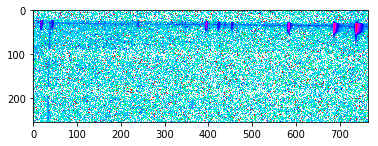

In [81]:
nebulae = sorted(glob.glob("data/nebula_reduced.fits"))
nebulae = list(map(fits.open, nebulae[:]))
nebulae = nebulae[0][0].data
plt.imshow(nebulae, cmap='hsv',norm=LogNorm(vmin=.0000001, vmax=2.5));

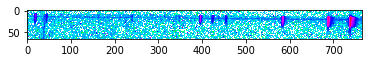

In [82]:
nebulae = nebulae[15:80, :]
plt.imshow(nebulae, cmap='hsv',norm=LogNorm(vmin=.0000001, vmax=2.5));

In [83]:
neb_norm = nebulae[0:40,:]/data_fitfunc(x)
sky_norm = nebulae[40:65,:]/data_fitfunc(x)#divide out data fit and destroy everything we worked for
mean = np.median(neb_norm, axis=0)
sky_mean = np.median(sky_norm, axis=0)
mean = mean-sky_mean
std_dev = np.std(neb_norm, axis = 0)
# x = np.linspace(b, b+len(mean)*m, len(mean))
# plt.plot(x,mean) 
#data_fitfunc = np.poly1d(np.polyfit(x,mean,3))
#plt.plot(x,data_fitfunc(x))
#.97 is the angstroms per pixel that was previously calculated in lab0
# plt.title("Spectrum with log scale")
# plt.yscale('log')
# plt.xlabel("Angstroms")
# plot on logscale so that all emission lines are very visible
# plt.ylabel("Relative Flux (log)");

In [126]:
def peaks(data,epi):
    indices, = np.nonzero(data > epi)
    jumps = (indices[1:] - indices[:-1]) != 1
    # print([(i, jump) for i, jump in zip(indices, jumps)])

    lows = list(indices[1:][jumps])
    highs = list(indices[:-1][jumps])

    lows = [indices[1:].min()-2] + lows
    highs = highs + [indices.max()+2]

    indices = [data[lo:hi+1].argmax() + lo if lo != hi else lo
               for lo, hi in zip(lows, highs)]

    indices = np.array(indices)
    return indices,np.array(lows),np.array(highs)

In [127]:
indices,lows,highs = [],[],[]
epi = 1.75e14
ind1,low1,high1 = peaks(mean[0:300],epi)

epi = .7e14
ind2,low2,high2 = peaks(mean[300:],epi)

ind2 += 300
low2 += 300
high2 +=300

'''ind2 = np.delete(ind2,1)
low2 = np.delete(low2,1)
high2 = np.delete(high2,1)'''

indices = np.append(ind1,ind2)
lows = np.append(low1,low2)
highs = np.append(high1,high2)
indices, lows, highs

(array([ 19,  43, 395, 423, 455, 583, 688, 738]),
 array([ 16,  43, 392, 422, 453, 581, 684, 734]),
 array([ 20,  47, 397, 424, 455, 587, 696, 754]))

In [128]:
theory = np.array([4341,4363,4686,4711,4740,4861,4959,5007])
m, b = np.polyfit(indices,theory,1)
#obtain a better estimate for the dispersion and for the shifting needed
# m is the better 'ang_per_pix' and b is the better 'shift'

In [129]:
def descend_from_peak(i, direction=1):
    
    peak_loc = indices[i]
    
    if direction > 0: j = max(highs[i]-1, peak_loc)
    else: j = min(lows[i]+1, peak_loc)
    
    while True:
        
        delta = mean[j+1] - 2*mean[j] + mean[j-1]
        sign = delta / np.abs(delta)
        if sign > 0:
            return j
        j += direction

In [130]:
def gaussian(x, *params):
    """
    Models a Gaussian distribution. To convert to a function that only takes the independent variable,
    use fixed_params.
    :param x: Independent variable.
    :param params: The parameters of the distribution, in the order amplitude, variance (sigma), and mean (mu).
    :return: The value of the distribution at x.
    """

    A, var, mu = params
    return A / np.sqrt(2 * np.pi * var) * np.exp(-(x - mu)**2 / (2 * var))

def gaussian_fit(x, y, err_y=None):
    """
    Fits a Gaussian distribution to the input data.
    :param x: The sequence of x values for the dataset.
    :param y: The sequence of y values for the dataset.
    :param err_x: The errors in the x values.
    :param err_y: The errors in the y values.
    :return: A two dimensional array, containing first the values of the parameters and then the corresponding errors.
        The parameters are amplitude, variance and mean (mu) respectively.
    """

    mu = np.mean(x)
    var = np.var(x)
    A = max(y) * np.sqrt(2 * np.pi * var)

    p0 = A, var, mu

    # Return the correct fit based on the input errors
    res = curve_fit(gaussian, x, y, p0, err_y)
    return res[0], res[1]

In [138]:
peak_sums = []
for i in range(len(lows)):
    peak_sums.append( [np.trapz(mean[lows[i]:highs[i]+1])/1e14, indices[i]*m+b] )
peak_sums

[[20.697902483155445, 4339.619209001457],
 [5.9096157796305375, 4361.807527257009],
 [12.87040872436685, 4687.236195005098],
 [1.9799913960717537, 4713.122566303242],
 [1.7204795631380012, 4742.706990643977],
 [56.40370114886565, 4861.0446880069185],
 [316.7177619373122, 4958.118580374957],
 [1039.3926781749249, 5004.344243407356]]

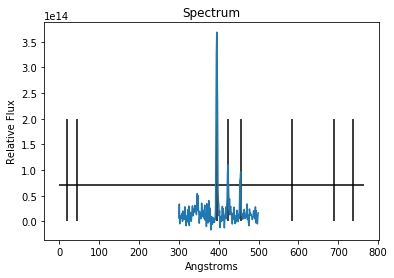

In [132]:
x = np.arange(0, len(mean))#*m + b
plt.plot(x[300:500],mean[300:500])
plt.title("Spectrum")
plt.xlabel('Angstroms')
plt.hlines(.7e14, x[0], x[len(x)-1])
plt.vlines(indices, 0, 2e14)
plt.ylabel('Relative Flux');
#plt.savefig("camel_line.png", dpi=600);

In [133]:
np.savetxt('emission_line_strengths.csv', peak_sums, delimiter=',')

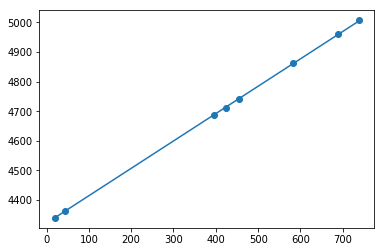

In [134]:
plt.scatter(indices,theory)
y = np.poly1d(np.polyfit(indices,theory,1))
plt.plot(indices,y(indices))

In [139]:
oxygen_ratio = (peak_sums[6][0] + peak_sums[7][0]) / (peak_sums[1][0]) 
n_e = 2.5*10**3

def funky(T):
    return 7.9*np.exp(3.29e4/T) / (1+4.5e-4*n_e*T**(-0.5)) - oxygen_ratio
Temperature = newton(funky,10000)

In [140]:
argon_ratio = peak_sums[4][0] / peak_sums[5][0]
argon_ratio

0.03050295509149584

In [23]:
print("Calculated Temperature: ", round(Temperature,3), " Literature value: 12500")
print('N_e calculated from ratio and graph: ~2.5e3 Literature Value: 3e3')

Calculated Temperature:  13121.243  Literature value: 12500
N_e calculated from ratio and graph: ~2.5e3 Literature Value: 3e3


Page 7 of https://arxiv.org/pdf/astro-ph/0003410.pdf gives N_e of NGC 7662

Error in progress

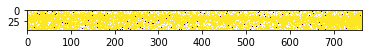

In [24]:
plt.imshow(neb_norm,norm=LogNorm(vmin=.0000001, vmax=2.5));

In [25]:
Temperature

13121.242802934026

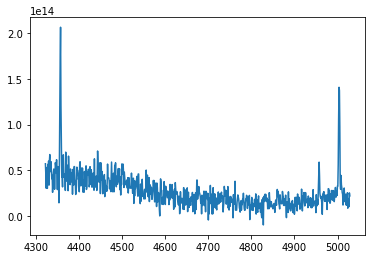

In [41]:
plt.plot(x[:len(sky_mean)],sky_mean)